In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import cos, sin, exp

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

# Geração de sinais ópticos

Num sistema de comunicação digital óptica, a função do transmissor é converter uma dada sequência de bits num trem de pulsos elétricos que, por sua vez, será utilizado na modulação de uma portadora óptica (laser). A modulação de portadoras ópticas é realizada por meio de dispositivos de conversão eletro-óptica.

Diversas técnicas de modulação podem ser implementadas e diversos fatores podem influenciar o projeto de um transmissor óptico. 

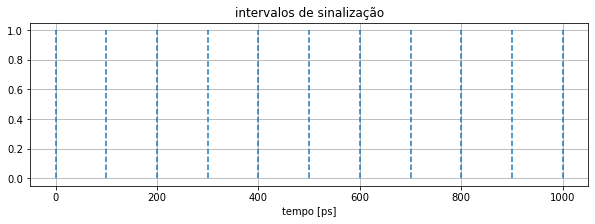

In [4]:
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos

t = np.arange(0, 11*Ts, Ts)/1e-12

for ind in range(0, 11):
    plt.vlines(t[ind], 0, 1, linestyles='dashed')
    
plt.xlabel('tempo [ps]');
plt.title('intervalos de sinalização');
plt.grid()

## Formatos de modulação

$\mathbf{E}(t)=\hat{\mathbf{e}} A \cos \left(\omega_c t + \phi\right)$ em que $\omega_c = 2\pi f_{c}$ rad/s

In [5]:
ϕ, omega_c, A, t = sp.symbols('ϕ, omega_c, A, t', real=True)

j = sp.I
π = sp.pi

E = A*cos(omega_c*t + ϕ)
E

A*cos(omega_c*t + ϕ)

$\mathbf{E}(t)=\operatorname{Re}\left[\hat{\mathbf{e}} A e^{j \phi} \exp \left(j \omega_c t\right)\right]$

In [6]:
sp.re(A*exp(j*ϕ)*exp(j*omega_c*t)).simplify()

A*cos(omega_c*t + ϕ)

In [7]:
sp.expand_trig(E).cancel()

-A*sin(ϕ)*sin(omega_c*t) + A*cos(ϕ)*cos(omega_c*t)

### Chaveamento por deslocamento de amplitude (*amplitude shift-keing* - ASK) ou modulação de amplitude de pulso (*pulse amplitude modulation* - PAM)

$ E(t)=\operatorname{Re}\left[A(t) e^{j \phi} \exp \left(j \omega_c t\right)\right]$

$ A_{0}(t)=\sqrt{P_{0}} \sum_{n} b_{n} p\left(t-n T_{s}\right)$

In [8]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram

In [9]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem
P0     = 1             # Potência

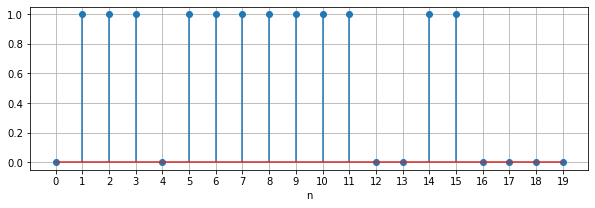

In [10]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=20)    
n      = np.arange(0, bits.size)

# mapeia bits para símbolos OOK
symbTx = np.sqrt(P0)*bits

plt.figure(1)
plt.stem(symbTx, use_line_collection=True)
plt.xlabel('n')
plt.grid()
plt.xticks(np.arange(0, bits.size));

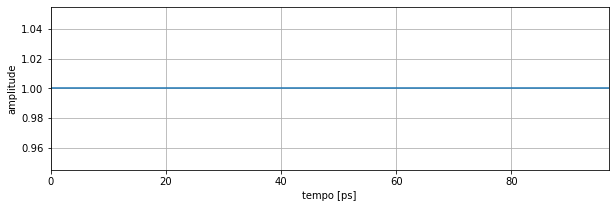

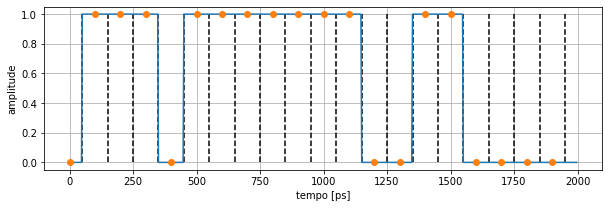

In [11]:
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso retangular ideal
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'pulso')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

# plota sinal 
t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-')
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
for ind in range(0, bits.size):
    plt.vlines(t[ind], 0, 1, linestyles='dashed', color = 'k')

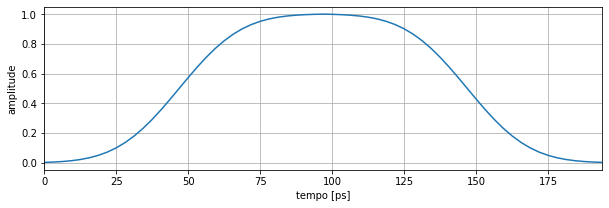

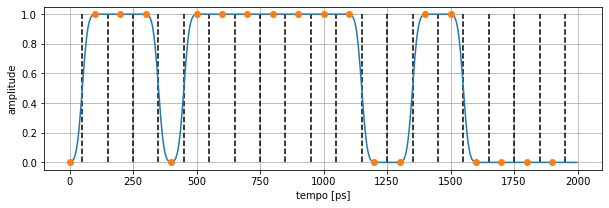

In [12]:
# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'pulso')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso retangular
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-')
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
for ind in range(0, bits.size):
    plt.vlines(t[ind], 0, 1, linestyles='dashed', color = 'k')

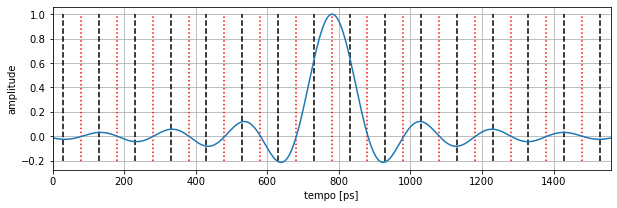

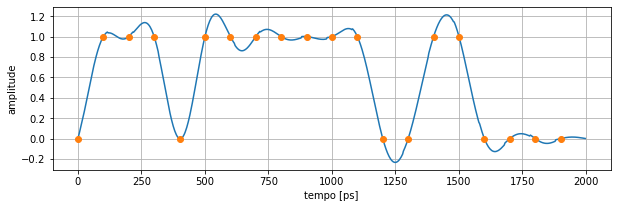

In [13]:
# pulso cosseno levantado (raised cosine)
Ncoeffs = 500
rolloff = 0.1

pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'pulso')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()

t = (-0.2*Ts + np.arange(0, (Ncoeffs/SpS)*Ts, Ts))/1e-12
for ind in range(0, t.size):
    plt.vlines(t[ind], -0.2, 1, linestyles='dotted', color='r')
    plt.vlines(t[ind]+ 0.5*(Ts/1e-12), -0.2, 1, linestyles='dashed', color = 'k')

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso 
sigTx  = firFilter(pulse, symbolsUp)

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(2*bits-1, SpS)
symbolsUp[symbolsUp==0] = np.nan
symbolsUp = (symbolsUp + 1)/2

plt.figure(2)
plt.plot(t, sigTx.real,'-')
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ps]')
plt.ylabel('amplitude')
plt.grid()

## Densidade espectral de potência do sinal modulado

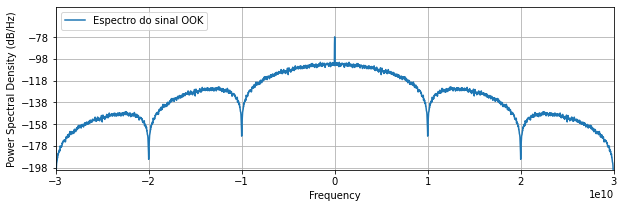

In [14]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para símbolos OOK
symbTx = bits
symbTx = np.sqrt(P0)*symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso cosseno levantado (raised cosine)
Ncoeffs = 2000
rolloff = 0.01

# pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
# pulse = pulse/max(abs(pulse))

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

In [15]:
Nsamples = 20000

# # diagrama de olho
# eyediagram(sigTx, Nsamples, SpS, n=3)

### PAM4

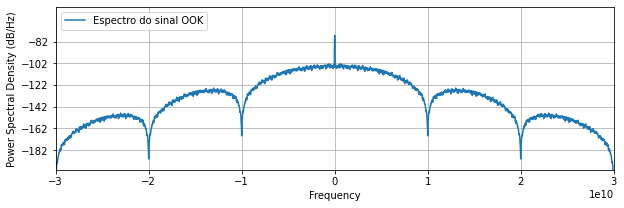

In [16]:
# gera sequência de bits pseudo-aleatórios
bits1   = np.random.randint(2, size=10000)  
bits2   = np.random.randint(2, size=10000) 

n      = np.arange(0, bits.size)

# mapeia bits para símbolos PAM4
symbTx = (2/3)*bits1 + (1/3)*bits2
symbTx = np.sqrt(P0)*symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal OOK')
plt.legend(loc='upper left');
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-200,-50);

C:\Users\edson\Documents\GitHub\OpticalCommunications\jupyter notebooks\utils\dsp.py:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1);


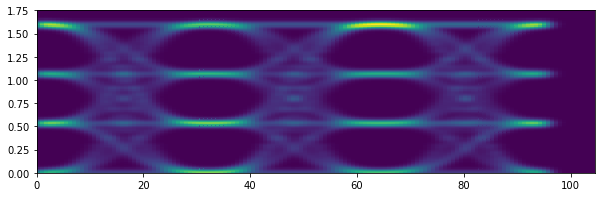

In [19]:
Nsamples = 20000

# diagrama de olho
eyediagram(sigTx, Nsamples, SpS, n=3)